In [ ]:
%pip install pandas
%pip install numpy
%pip install scikit-learn

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     -------------------------------------- 60.8/60.8 kB 815.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.0 MB 1.1 MB/s eta 0:00:11
    --------------------------------------- 0.2/11.0 MB 2.5 MB/s eta 0:00:05
   - -------------------------------------- 0.3/11.0 MB 2.2 MB/s eta 0:00:05
   - -------------------------------------- 0.5/11.0 MB 2.9 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/11.0 MB 2.6 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/11.0 MB 2.6 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/11.0 MB 1.8 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/11.0 MB 1.8 MB/s eta 0:00:06
   --- ------------------------------------ 0.9/11.0 MB 2.1 MB/s eta 0:00:05
   --- -----


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Atitude\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
sessions_path = 'content/sessions.jsonl'

sessions = pd.read_json(sessions_path, lines=True, encoding='utf-8')


tracks_path = 'content/tracks.jsonl'

tracks = pd.read_json(tracks_path, lines=True, encoding='utf-8')



users_path = 'content/users.jsonl'

users = pd.read_json(users_path, lines=True, encoding='utf-8')


artists_path = 'content/artists.jsonl'

artists = pd.read_json(artists_path, lines=True, encoding='utf-8')


In [9]:
print(f'sessions: {sessions.columns}')
print(f'tracks: {tracks.columns}')
print(f'users: {users.columns}')
print(f'artists: {artists.columns}')


sessions: Index(['timestamp', 'user_id', 'track_id', 'event_type', 'session_id'], dtype='object')
tracks: Index(['id', 'artist_id', 'name', 'popularity', 'duration_ms', 'explicit',
       'release_date', 'danceability', 'energy', 'key', 'mode', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')
users: Index(['user_id', 'name', 'city', 'street', 'favourite_genres',
       'premium_user'],
      dtype='object')
artists: Index(['id', 'name', 'genres'], dtype='object')


In [11]:
sessions['timestamp'] = pd.to_datetime(sessions['timestamp'])
sessions['date'] = sessions['timestamp'].dt.strftime('%Y-%m-%d')
sessions['month'] = sessions['timestamp'].dt.strftime('%Y-%m')

In [12]:
# sessions: Index(['timestamp', 'user_id', 'track_id', 'event_type', 'session_id'], dtype='object')
track_id_duration = dict(zip(tracks['id'], tracks['duration_ms']))
# Map values to a new column using a dictionary
sessions['track_len'] = sessions['track_id'].map(track_id_duration)
sessions['duration_ms'] = 0
# [conditions, what to modify] = new value for selected by condtions columns to modify
sessions.loc[sessions['event_type'] == "Play", 'duration_ms'] = sessions['track_len']
# @TODO see time between play and skip and in the duration ms put - only the time that the song was plahyed
sessions.loc[sessions['event_type'] == "Skip", 'duration_ms'] = -sessions['track_len']

In [13]:
sessions['song_played_in_full'] = sessions['event_type'].map({"Play":1,"Skip":-1}).fillna(0)


In [14]:
sessions['song_liked'] = sessions['event_type'].map({"Like":1}).fillna(0)
sessions['Advertisment_played'] = sessions['event_type'].map({"Advertisement":1}).fillna(0)

Definicja tych atrbutów:
- x Ilość wysłuchanych piosenek
- Średnia ilość wysłuchanych piosenek w sesji,dniu
- Ilość sesji
- Skip rate na sesje,dzień
- x Czas słuchania full
- średni czas słuchania dzienny
- Czas słuchania w jednej sesji
- Ilość polubionych piosenek na wysłuchane


In [16]:
# total time user listened
duration_played_ms = sessions.groupby("user_id")['duration_ms'].sum().reset_index()
users = pd.merge(users, duration_played_ms, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'duration_ms': 'total_time_songs_played_ms'}, inplace=True)

In [17]:
# ototal number of songs played
count_of_songs_played_in_full = sessions.groupby("user_id")["song_played_in_full"].sum().reset_index()
users = pd.merge(users, count_of_songs_played_in_full, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'song_played_in_full': 'nr_song_played_in_full'}, inplace=True)


In [ ]:
# Number of songs played average day
df = sessions.groupby(["user_id", 'date'])["song_played_in_full"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_played_in_full"].mean().reset_index()
df.rename(columns={'song_played_in_full': 'avg_nr_songs_played_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636


In [19]:
users.describe()

,user_id,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day
count,3000.000000,3.000000e+03,3000.000000,3000.000000
mean,1600.500000,4.333224e+07,198.489333,15.188397
std,866.169729,2.108558e+07,104.305288,5.591425
min,101.000000,6.764083e+06,27.000000,4.500000
25%,850.750000,2.692320e+07,117.000000,10.000000
50%,1600.500000,3.981109e+07,175.000000,14.612500
75%,2350.250000,5.589680e+07,264.000000,20.142857
max,3100.000000,1.072634e+08,515.000000,34.166667


In [ ]:
# Number of songs played average session
df = sessions.groupby(["user_id", 'session_id'])["song_played_in_full"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_played_in_full"].mean().reset_index()
df.rename(columns={'song_played_in_full': 'avg_nr_songs_played_per_session'}, inplace=True)
df.describe()

users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636


In [ ]:
# length of songs played average session 
df = sessions.groupby(["user_id", 'session_id'])["duration_ms"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["duration_ms"].mean().reset_index()
df.rename(columns={'duration_ms': 'avg_time_playing_by_session'}, inplace=True)
df.describe()
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06


In [ ]:
# length of songs played average  day
df = sessions.groupby(["user_id", 'date'])["duration_ms"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["duration_ms"].mean().reset_index()
df.rename(columns={'duration_ms': 'avg_time_playing_in_a_day'}, inplace=True)
df.describe()
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06


In [ ]:
# number of unique songs played
df = sessions.groupby(["user_id", 'track_id'])["song_played_in_full"].sum().reset_index()
df["was_song_played"] = 0
df.loc[df["song_played_in_full"] > 0, 'was_song_played'] = 1
df = df.groupby(["user_id"])["was_song_played"].count().reset_index()
df.rename(columns={'was_song_played': 'number_of_unique_songs_listened_through'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200


In [ ]:
# number of songs liked and advertisments heard
df = sessions.groupby(["user_id"])["song_liked"].sum().reset_index()
df.rename(columns={'song_liked': 'nr_of_songs_liked'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through,nr_of_songs_liked
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146,10.0
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142,46.0
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200,15.0


In [ ]:
# number of advertisments heard
df = sessions.groupby(["user_id"])["Advertisment_played"].sum().reset_index()
df.rename(columns={'Advertisment_played': 'nr_of_ads_heard'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through,nr_of_songs_liked,nr_of_ads_heard
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146,10.0,38.0
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142,46.0,43.0
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200,15.0,53.0


In [26]:
# Number of ads heard per day day
df = sessions.groupby(["user_id", 'date'])["Advertisment_played"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["Advertisment_played"].mean().reset_index()
df.rename(columns={'Advertisment_played': 'nr_of_ads_heard_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

df = sessions.groupby(["user_id", 'date'])["song_liked"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_liked"].mean().reset_index()
df.rename(columns={'song_liked': 'nr_of_songs_liked_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

users.head(3)

,user_id,name,city,street,favourite_genres,premium_user,total_time_songs_played_ms,nr_song_played_in_full,avg_nr_songs_played_per_day,avg_nr_songs_played_per_session,avg_time_playing_by_session,avg_time_playing_in_a_day,number_of_unique_songs_listened_through,nr_of_songs_liked,nr_of_ads_heard,nr_of_ads_heard_per_day,nr_of_songs_liked_per_day
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,19.000000,3.948851e+06,3.948851e+06,146,10.0,38.0,4.750000,1.250000
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,10.142857,2.414890e+06,2.414890e+06,142,46.0,43.0,6.142857,6.571429
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,18.363636,3.620877e+06,3.620877e+06,200,15.0,53.0,4.818182,1.363636


In [ ]:
users["is_premium"] = users["premium_user"].map({True:1,False:0})

# Analiza wygenerowanych atrybutów

In [98]:
X = users[[
    # 'user_id', 
# 'name', 'city', 'street', 'favourite_genres', 'premium_user',
       'total_time_songs_played_ms', 'nr_song_played_in_full',
       'avg_nr_songs_played_per_day', 'avg_nr_songs_played_per_session',
       'avg_time_playing_by_session', 'avg_time_playing_in_a_day',
       'number_of_unique_songs_listened_through', 'nr_of_songs_liked',
       'nr_of_ads_heard', 'nr_of_ads_heard_per_day',
       'nr_of_songs_liked_per_day', 
    #    'is_premium'
       ]]

Y = users[[
    # 'user_id', 
# 'name', 'city', 'street', 'favourite_genres', 'premium_user',
    #    'total_time_songs_played_ms', 'nr_song_played_in_full',
    #    'avg_nr_songs_played_per_day', 'avg_nr_songs_played_per_session',
    #    'avg_time_playing_by_session', 'avg_time_playing_in_a_day',
    #    'number_of_unique_songs_listened_through', 'nr_of_songs_liked',
    #    'nr_of_ads_heard', 'nr_of_ads_heard_per_day',
    #    'nr_of_songs_liked_per_day', 
       'is_premium'
       ]]
Y = (Y*2)-1

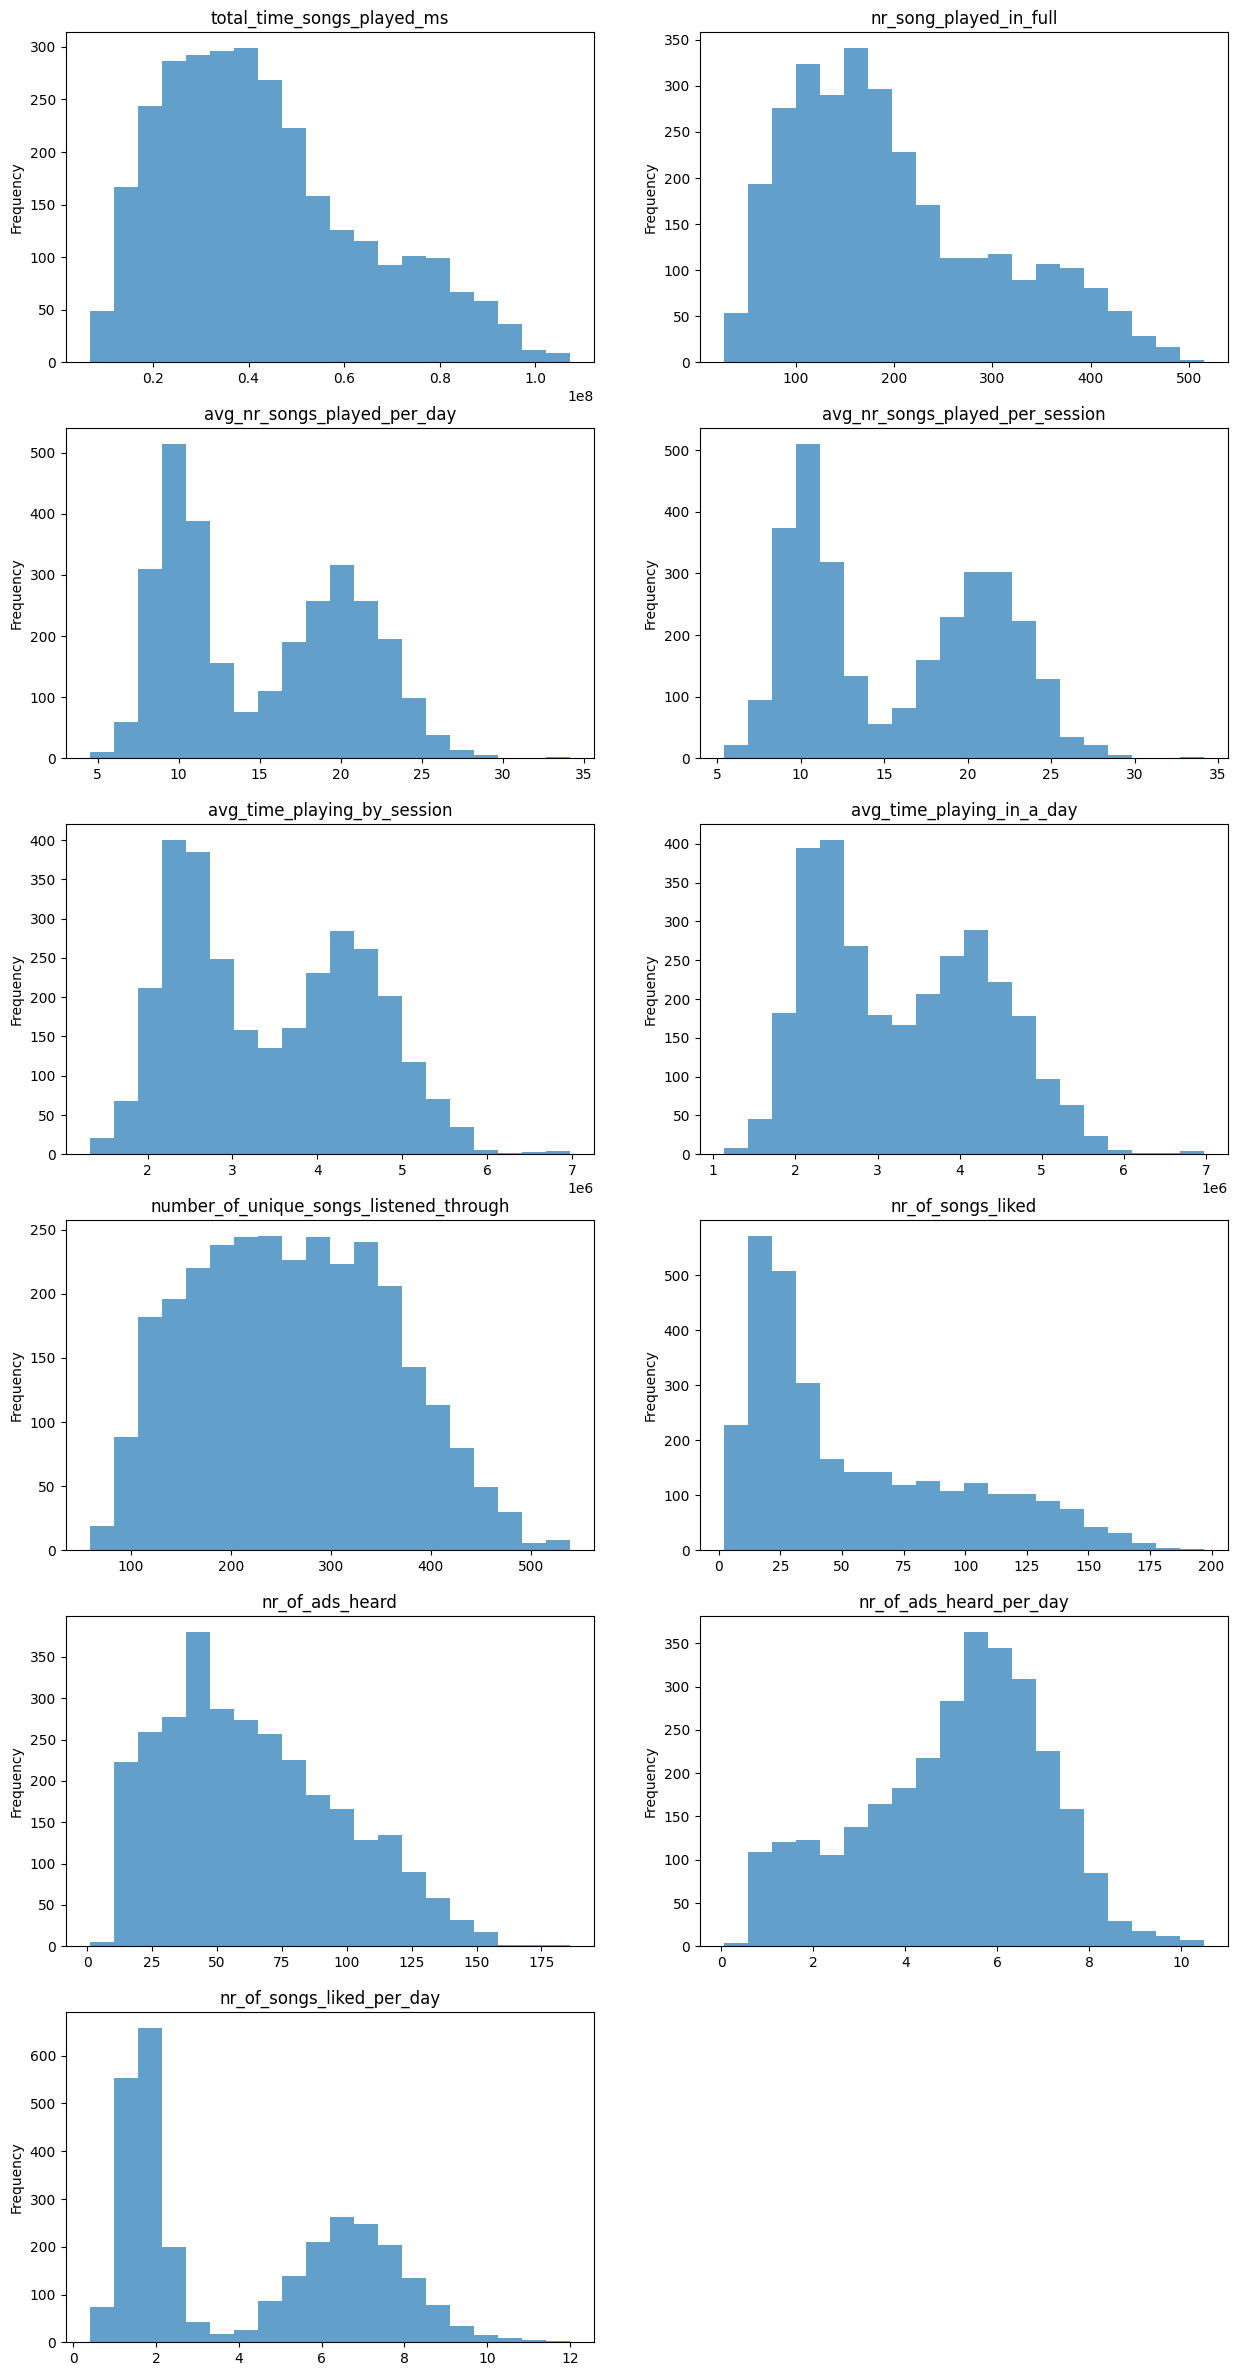

In [99]:

n_attributes = len(X.keys())

n_cols = 2  
n_rows = (n_attributes // n_cols) + (n_attributes % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

for idx, (x, ax) in enumerate(zip(X.keys(), axes)):
    X[x].plot(kind="hist", bins=20, alpha=0.7, ax=ax)
    ax.set_title(f"{x}")
    # ax.set_xlabel(x) 
    ax.set_ylabel('Frequency')  

for idx in range(n_attributes, len(axes)):
    axes[idx].axis('off')

plt.show()


In [100]:
# Standaryzacja wartości w X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(X_standardized)


      total_time_songs_played_ms  nr_song_played_in_full  \
0                      -0.556939               -0.445779   
1                      -1.253578               -1.222475   
2                      -0.166141                0.033663   
3                       1.449822                1.587055   
4                      -1.556677               -1.433429   
...                          ...                     ...   
2995                    1.522619                1.481578   
2996                    1.295196                1.404867   
2997                   -0.898467               -0.858099   
2998                   -0.852320               -0.906043   
2999                    0.005185               -0.158114   

      avg_nr_songs_played_per_day  avg_nr_songs_played_per_session  \
0                        0.681801                         0.556530   
1                       -0.902521                        -0.987815   
2                        0.567971                         0.445573   

In [ ]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

# Fit the model to the data
model.fit(X_standardized, Y)
Xs = X_standardized+1
Yp = model.predict(Xs)

# Get the regression coefficients (parameters)
print("Bias:", model.intercept_)
print("Coefficient:", model.coef_)
# If you have feature names, use them; if not, use numbers as feature labels
feature_names = [f'{str(i)}' for i in X_standardized.keys()]  # Change if you have actual names
weights = model.coef_[0]

Bias: [-0.168]
Coefficient: [[ 0.24341803 -0.47069013  1.6941063  -1.58160746  1.45746472 -1.41805813
   0.67605591 -0.64266918 -0.0957057  -0.48052586  0.74421418]]


In [120]:
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
print("MSE:", mean_squared_error(Y,np.sign(Yp)))
print("R2:", r2_score(Y,np.sign(Yp)))
print("Confusion Matrix:", confusion_matrix(Y,np.sign(Yp)))
# print([1 for v in Y.values if v == 1 ])
print(f"Y 1s {sum([1 for v in Y.values if v == 1 ])}  0s {sum([1 for v in Y.values if v == -1 ])}")
print(f"Yp 1s {sum([1 for v in np.sign(Yp) if v == 1 ])}  0s {sum([1 for v in np.sign(Yp) if v == -1 ])}")



MSE: 0.45066666666666666
R2: 0.5362442922374429
Confusion Matrix: [[1743    9]
 [ 329  919]]
Y 1s 1248  0s 1752
Yp 1s 928  0s 2072


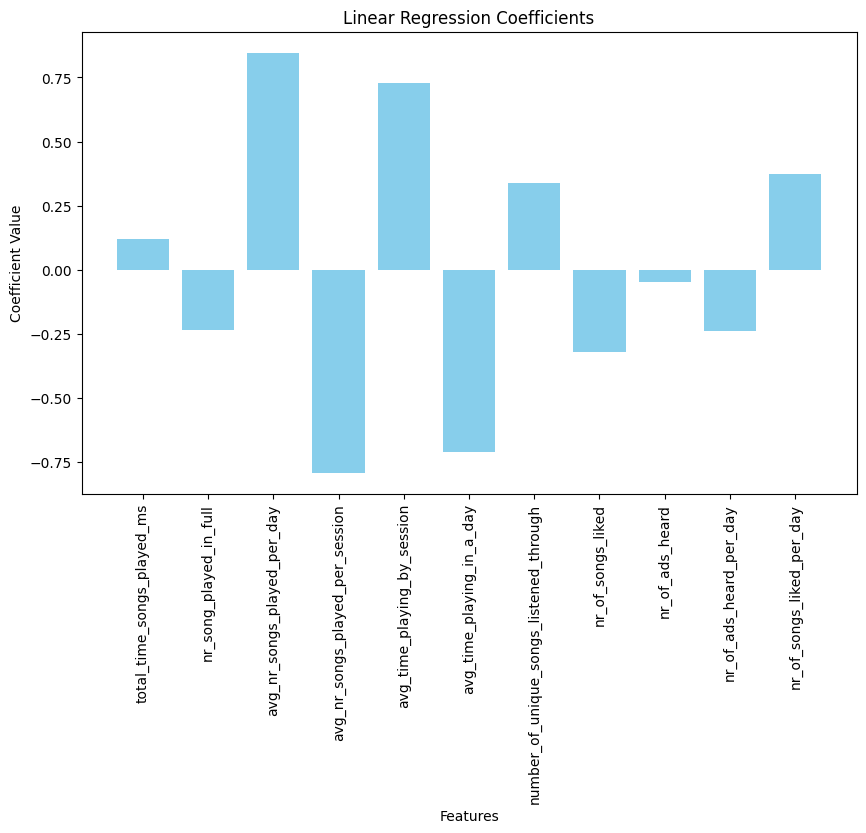

In [91]:

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, model.coef_[0], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=90)
plt.show()



